## モデル構築

In [1]:
#データの収集

%matplotlib inline
import numpy as np
import torch

import matplotlib.pyplot as plt

In [2]:
#t_cは摂氏
#t_uは単位が知りたい値
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

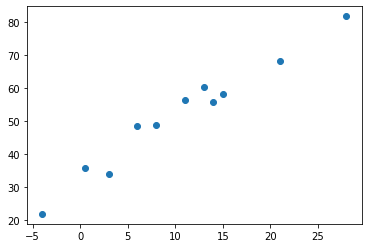

In [3]:
plt.scatter(t_c, t_u)

In [4]:
#データを収集したら、可視化、線形モデルをためす。
#線形モデル　t_c = w * t_u + b
#予測値と測定値の誤差が小さくなるようにモデルのパラメータ（ｗ：重みとｂ：バイアス）を推定する
#誤差の測定方法に損失関数を用いる
#この損失関数が最小になるようなw,bを見つけることを目標とする

## パラメータの推定と損失関数

In [5]:
#モデル作成
def model (t_u, w, b):
    return w* t_u + b

In [6]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [7]:
#パラメータの初期化
w = torch.ones(())
b = torch.zeros(())

In [8]:
w

tensor(1.)

In [9]:
t_p = model(t_u ,w ,b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [10]:
#この段階で損失
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

# ブロードキャスティング

In [11]:
#あるテンソルの１つが、他のテンソルよりも大きい次元の場合に他のテンソル全体にあるテンソルの次元に沿った
#計算がされる
import torch
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)
print(f"shape: x:{x.shape} y:{y.shape}")
print(f"z:{z.shape}, a:{a.shape}")
print("x * y:", (x*y).shape)
print("y * z:", (y*z).shape)
print("x * z * a:", (y*z*a).shape)

shape: x:torch.Size([]) y:torch.Size([3, 1])
z:torch.Size([1, 3]), a:torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
x * z * a: torch.Size([2, 3, 3])


In [12]:
z,a

(tensor([[1., 1., 1.]]),
 tensor([[[1.]],
 
         [[1.]]]))

In [13]:
#損失を小さくするためには

# 勾配降下法

In [14]:
#各パラメータに対する損失の変化率を計算し、損失が減少する方向に
#各パラメータを補正する

In [15]:
delta = 0.1

#wの変化が損失につながる
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b),t_c)-
 loss_fn(model(t_u, w - delta, b), t_c)) /(2.0 * delta)

In [16]:
loss_rate_of_change_w 
#この損失の変化量が負の場合は損失を最小化するためにwを増加させる必要がある
#変化量が正の場合はwを減少させる必要がある

#どのくらい変化させた方がいいか
#損失の変化量に比例した変更をwに適用したらよいのではないか
#変化量を調整する係数を学習率と呼ぶ

tensor(4517.2974)

In [17]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta),t_c)-
 loss_fn(model(t_u, w, b - delta),t_c))/(2.0 * delta)

In [18]:
b = b - learning_rate * loss_rate_of_change_b
b

tensor(46.)

In [21]:
#損失関数を再び定義
def loss_fn(t_p, t_c):
    squred_differs= (t_p -t_c)**2
    return squred_differs.mean()

In [22]:
loss_fn(t_p, t_c)

tensor(1763.8848)

In [23]:
#モデルは線形 dx*2 /dx = 2x
#損失の導関数は
def dloss_fn(t_p, t_c):
    dsq_diffs = 2*(t_p - t_c) / t_p.size(0)#除算は平均化のため
    return dsq_diffs

In [24]:
dloss_fn(t_p, t_c), t_p.shape

(tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091,
         8.6182, 8.6182]),
 torch.Size([11]))

In [25]:
#model　は　w*t_u + b 

#このmodelの導関数は
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [26]:
#勾配の関数
#損失に勾配（導関数のベクトル）を掛ける
def  grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)#損失
    dloss_dw  = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db  = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])
    
#この出力を(学習率をかけてから）各パラメータに加えることで最適化

In [37]:
#反復して繰り返す必要がある
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs +1):
        w, b = params
        #順伝播
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        #逆伝播
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
      
        
        #パラメータの更新
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % ( epoch, float(loss)))
        print(f"grad:{grad}")
        print(f"params:{params}")
        
    return params

In [38]:
training_loop(
    n_epochs = 20,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
grad:tensor([4517.2964,   82.6000])
params:tensor([-44.1730,  -0.8260])
Epoch 2, Loss 5802484.500000
grad:tensor([-261257.4062,   -4598.9702])
params:tensor([2568.4011,   45.1637])
Epoch 3, Loss 19408029696.000000
grad:tensor([15109614.0000,   266155.6875])
params:tensor([-148527.7344,   -2616.3931])
Epoch 4, Loss 64915905708032.000000
grad:tensor([-8.7385e+08, -1.5393e+07])
params:tensor([8589999.0000,  151310.8906])
Epoch 5, Loss 217130525461053440.000000
grad:tensor([5.0539e+10, 8.9023e+08])
params:tensor([-4.9680e+08, -8.7510e+06])
Epoch 6, Loss 726257583152928129024.000000
grad:tensor([-2.9229e+12, -5.1486e+10])
params:tensor([2.8732e+10, 5.0610e+08])
Epoch 7, Loss 2429183416467662896627712.000000
grad:tensor([1.6904e+14, 2.9776e+12])
params:tensor([-1.6617e+12, -2.9270e+10])
Epoch 8, Loss 8125122549611731432050262016.000000
grad:tensor([-9.7764e+15, -1.7221e+14])
params:tensor([9.6102e+13, 1.6928e+12])
Epoch 9, Loss 27176882120842590626938030653440.00000

tensor([1.3457e+35, 2.3704e+33])


損失が無限大になった

この訓練では変数が大きすぎる更新を受け取ったことを示す兆候である
各更新がオーバーシュートして、次の更新がさらに過大評価され、最適化が収束する代わりに発散する
本来はどんどん小さくしていきたい

learning_rateは学習がうまくいかなかったときに変更することが多いパラメータの一つ

In [39]:
training_loop(
    n_epochs = 20,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
grad:tensor([4517.2964,   82.6000])
params:tensor([ 0.5483, -0.0083])
Epoch 2, Loss 323.090515
grad:tensor([1859.5493,   35.7843])
params:tensor([ 0.3623, -0.0118])
Epoch 3, Loss 78.929634
grad:tensor([765.4666,  16.5122])
params:tensor([ 0.2858, -0.0135])
Epoch 4, Loss 37.552845
grad:tensor([315.0790,   8.5787])
params:tensor([ 0.2543, -0.0143])
Epoch 5, Loss 30.540283
grad:tensor([129.6733,   5.3127])
params:tensor([ 0.2413, -0.0149])
Epoch 6, Loss 29.351154
grad:tensor([53.3495,  3.9682])
params:tensor([ 0.2360, -0.0153])
Epoch 7, Loss 29.148884
grad:tensor([21.9304,  3.4148])
params:tensor([ 0.2338, -0.0156])
Epoch 8, Loss 29.113848
grad:tensor([8.9964, 3.1869])
params:tensor([ 0.2329, -0.0159])
Epoch 9, Loss 29.107145
grad:tensor([3.6721, 3.0930])
params:tensor([ 0.2325, -0.0162])
Epoch 10, Loss 29.105247
grad:tensor([1.4803, 3.0544])
params:tensor([ 0.2324, -0.0166])
Epoch 11, Loss 29.104168
grad:tensor([0.5781, 3.0384])
params:tensor([ 0.2323, -0.0169])

tensor([ 0.2323, -0.0196])

今度はlearnig_rateが小さく、更新も小さく途中で終わってしまった
adaptiveな変更が良いのではないか

もう一つ問題がある

## 入力の正規化




勾配の大きさが重みと、バイアスで約50倍の差がある
これはこれらのパラメータのスケールが異なるため

片方のスケールに合わせた学習率では片方では大きすぎるか、または小さすぎる可能性がある。

解決には問題の定式化の変更が必要
入力の範囲を―１から１の範囲に収めればよいのではないか